## Setup

In [1]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

# uncomment when acttually working on this, it's here for reproducibility though
fix_all_rngs(42) 

Using TensorFlow backend.


## Load data

> size: 1351


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
weekday      int64
dtype: object

,close,open,high,low,volume,missing,weekday
datetime,,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0,6
2015-02-02,238.0,214.8,242.0,214.8,6.42,0,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0,1
2015-02-04,227.0,227.4,231.0,220.0,14.31,0,2
2015-02-05,217.0,227.0,228.9,213.6,4.31,0,3


,close,open,high,low,volume,missing,weekday
datetime,,,,,,,
2018-10-09,6588.8,6604.8,6623.1,6553.1,2.25,0,1
2018-10-10,6517.5,6588.7,6589.8,6400.0,5.18,0,2
2018-10-11,6161.0,6517.5,6518.4,6067.0,9.62,0,3
2018-10-12,6184.9,6152.8,6238.3,6109.8,3.25,0,4
2018-10-13,6195.0,6180.8,6214.1,6168.8,2.27,0,5


> size: 933


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
dtype: object

,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-02,2020.85,1996.67,2021.66,1980.90,NaN,0
2015-02-03,2050.03,2022.71,2050.30,2022.71,NaN,0
2015-02-04,2041.51,2048.86,2054.74,2036.72,NaN,0
2015-02-05,2062.52,2043.45,2063.55,2043.45,NaN,0
2015-02-06,2055.47,2062.28,2072.40,2049.97,NaN,0


,close,open,high,low,volume,missing
datetime,,,,,,
2018-10-08,2884.43,2877.53,2889.45,2862.08,NaN,0
2018-10-09,2880.34,2882.51,2894.83,2874.27,NaN,0
2018-10-10,2785.68,2873.90,2874.02,2784.86,NaN,0
2018-10-11,2728.37,2776.87,2795.14,2710.51,NaN,0
2018-10-12,2767.13,2770.54,2775.77,2729.44,NaN,0


> size: 79


headline_text     object
sentiment        float64
dtype: object

,headline_text,sentiment
datetime,,
2011-05-14,race call btc cup doomben,0.3
2012-05-09,bufferings hopes slump after btc cup draw,0.0
2013-04-17,kohler value bitcoin gold,0.3
2013-05-11,cummings colt on song in btc cup,0.3
2013-10-26,us seizes bitcoins from man linked to silk road,-0.3


,headline_text,sentiment
datetime,,
2017-12-15,coinbase is going to add altcoins to its platf...,-0.4
2017-12-15,us prosecutors rush to sell bitcoin seized in ...,-0.4
2017-12-19,rob pyne turns to bitcoin for post political c...,0.0
2017-12-20,north korean hackers raiding bitcoin exchanges,-0.1
2017-12-23,bitcoin plunges in value after manic upward swing,0.2


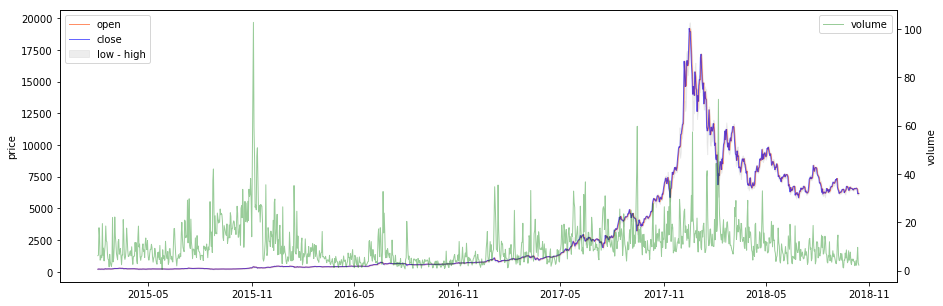

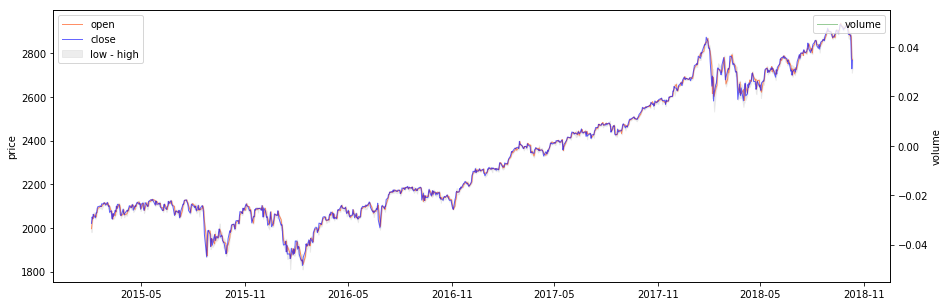

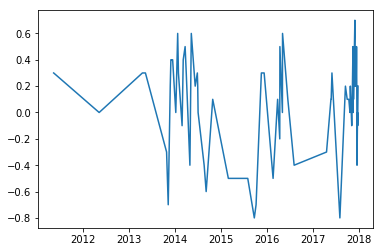

In [2]:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
SP500_FILENAME = './data_clean/sp500.csv'
NEWS_DATA_FILENAME = './data_clean/abcnews-date-text.with-sentiment.csv'

# load BTC @ 24 h data
data24h = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data24h))
data24h['weekday'] = data24h.index.dayofweek
dd(data24h.dtypes)
dd(data24h.head())
dd(data24h.tail())
simple_plot(data24h, show_xlabels=False)

# load SP500 data
data_sp500 = pd.read_csv(
    SP500_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data_sp500))
dd(data_sp500.dtypes)
dd(data_sp500.head())
dd(data_sp500.tail())
simple_plot(data_sp500, show_xlabels=False)

# add SP500-derived features to BTC @ 24 h data
data = etl.augment(data24h, data_sp500, 7, '_sp500')

# load bitcoin news with sentiment analysis data
data_news = pd.read_csv(
    NEWS_DATA_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data_news))
dd(data_news.dtypes)
dd(data_news.head())
dd(data_news.tail())
plt.figure(facecolor='white')
plt.plot(data_news.index.values, data_news['sentiment'])

# add news sentiment feature to data
data = etl.augment_with_news_sentiment(data, data_news, 30, '_last30d')

### Sanity inspect prediction data

In [3]:
print("> final data size:", len(data))
data.head()

> final data size: 1359


,close,open,high,low,volume,missing,weekday,close_sp500,slope_sp500,r2_sp500,sentiment,sentiment_last30d
datetime,,,,,,,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0,6,NaN,0.0,0.0,NaN,0.0
2015-02-02,238.0,214.8,242.0,214.8,6.42,0,0,2020.85,0.0,0.0,NaN,0.0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0,1,2050.03,0.0,0.0,NaN,0.0
2015-02-04,227.0,227.4,231.0,220.0,14.31,0,2,2041.51,0.0,0.0,NaN,0.0
2015-02-05,217.0,227.0,228.9,213.6,4.31,0,3,2062.52,0.0,0.0,NaN,0.0


In [4]:
data[data.index <= '2015-10-01'].tail(30)

,close,open,high,low,volume,missing,weekday,close_sp500,slope_sp500,r2_sp500,sentiment,sentiment_last30d
datetime,,,,,,,,,,,,
2015-09-02,228.8,227.6,230.8,226.0,21.57,0,2,1948.86,-6.011436e-14,0.169922,NaN,0.0
2015-09-03,226.8,228.8,230.0,226.5,19.71,0,3,1951.13,-1.107933e-13,0.617845,NaN,0.0
2015-09-04,231.1,226.8,231.4,226.3,20.89,0,4,1921.22,-9.094602e-14,0.410552,NaN,0.0
2015-09-05,235.4,231.1,237.2,229.2,20.03,0,5,NaN,-7.481481e-14,0.184559,NaN,0.0
2015-09-06,240.4,235.4,244.2,235.0,25.52,0,6,NaN,-7.481481e-14,0.184559,NaN,0.0
2015-09-07,240.1,240.4,242.9,238.4,23.16,0,0,NaN,-7.481481e-14,0.184559,NaN,0.0
2015-09-08,244.0,240.1,246.2,239.9,23.71,0,1,1969.41,2.821759e-14,0.027432,NaN,0.0
2015-09-09,238.0,244.0,244.2,237.0,23.26,0,2,1942.04,4.525602e-14,0.267580,NaN,0.0
2015-09-10,238.5,238.0,241.6,234.8,20.54,0,3,1952.29,3.076478e-14,0.152566,NaN,0.0


## Full runs

In [5]:
initial_model_constructor = make_rnn_model_constructor(
    [7, 0, 7, 0],
    optimizer=keras.optimizers.SGD,
    lr=1e-2,
)

DEFAULT_PARAMS = {
    # data to extract:
    'data_df': data,
    'train_sz': 300,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor(
        [7, 0.1, 7, 0.1],
        optimizer=keras.optimizers.RMSprop,
        lr=1e-4,
    ),
    # training:
    'epochs': 100,
    'batch_size': 32,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

CSV_FIELDS = (
    'model_description',
    'train_from',
    'train_to',
    'test_on',
    'shuffle',
    'normalize',
    'training_loss',
    'rmse',
    'rmse_cp',
    'dir_acc',
)

In [6]:
def ddump(s):
    """Print to both notebook and system stdout."""
    os.write(1, s)
    print(s)

In [7]:
def full_run(
    idx_from, idx_to, out_filename, write_csv_header, params,
    method=run_walk_forward_validation_rnn,
):
    train_sz = params['train_sz']
    test_sz = params['test_sz']
    
#     out_file = open(out_filename, 'ab')
    out_file = open(out_filename, 'wb')
    csv_writer = csv.DictWriter(out_file, fieldnames=CSV_FIELDS)
    if write_csv_header:
        csv_writer.writeheader()
        
    with timing('full run %d - %d' % (idx_from, idx_to)):
        for i in range(idx_from, idx_to, test_sz):
            params = dict(params,
                          from_i=i - train_sz)
            ddump("\n   ------ RUN %d (from %s, train on %d, test on %d)\n" % (
                i, params['from_i'], params['train_sz'], params['test_sz']))
            with timing('run segment'):
                out = run_walk_forward_validation_rnn(**params)
                del out['train_val_losses']
                csv_writer.writerow(out)
                out_file.flush()

## OHLCW predictions

In [8]:
OHLCW_PARAMS = DEFAULT_PARAMS.copy()
OHLCW_PARAMS['features'] = [
    'close', 'open', 'high', 'low', 'volume', 'weekday',
]

### initial


   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.016s to model compilation time


--- Created model id: 140523670966736
Tensor("lstm_1_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 7)              392       
_________________________________________________________________
lstm_2 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 820
Trainable params: 820
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_1/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 262 samples, validate on 30 samples
Epoch 1/100
262/262 [==============================] - 1s 3ms/step - loss: 0.0069 - val_loss: 

Epoch 70/100
262/262 [==============================] - 0s 394us/step - loss: 0.0043 - val_loss: 0.0186
Epoch 71/100
262/262 [==============================] - 0s 377us/step - loss: 0.0043 - val_loss: 0.0186
Epoch 72/100
262/262 [==============================] - 0s 353us/step - loss: 0.0043 - val_loss: 0.0186
Epoch 73/100
262/262 [==============================] - 0s 576us/step - loss: 0.0042 - val_loss: 0.0186
Epoch 74/100
262/262 [==============================] - 0s 500us/step - loss: 0.0042 - val_loss: 0.0186
Epoch 75/100
262/262 [==============================] - 0s 491us/step - loss: 0.0042 - val_loss: 0.0187
Epoch 76/100
262/262 [==============================] - 0s 356us/step - loss: 0.0042 - val_loss: 0.0187
Epoch 77/100
262/262 [==============================] - 0s 291us/step - loss: 0.0042 - val_loss: 0.0187
Epoch 78/100
262/262 [==============================] - 0s 303us/step - loss: 0.0042 - val_loss: 0.0187
Epoch 79/100
262/262 [==============================] - 0s 394us

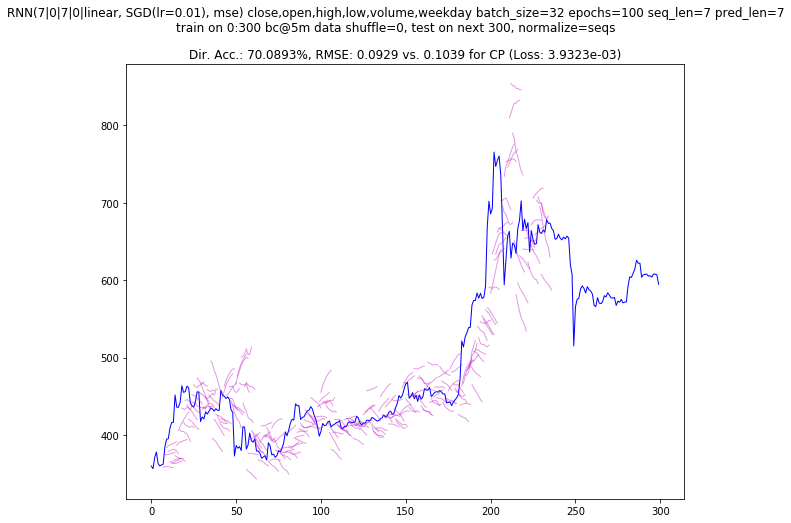

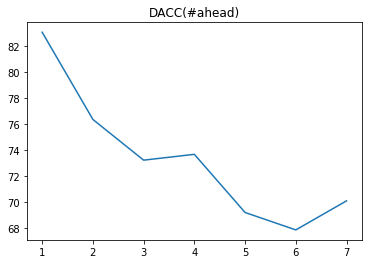

--- 11.478s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.015s to model compilation time


--- Created model id: 140522168512144
Tensor("lstm_3_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 7)              392       
_________________________________________________________________
lstm_4 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 820
Trainable params: 820
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_2/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 262 samples, validate on 30 samples
Epoch 1/100
262/262 [==============================] - 1s 5ms/st

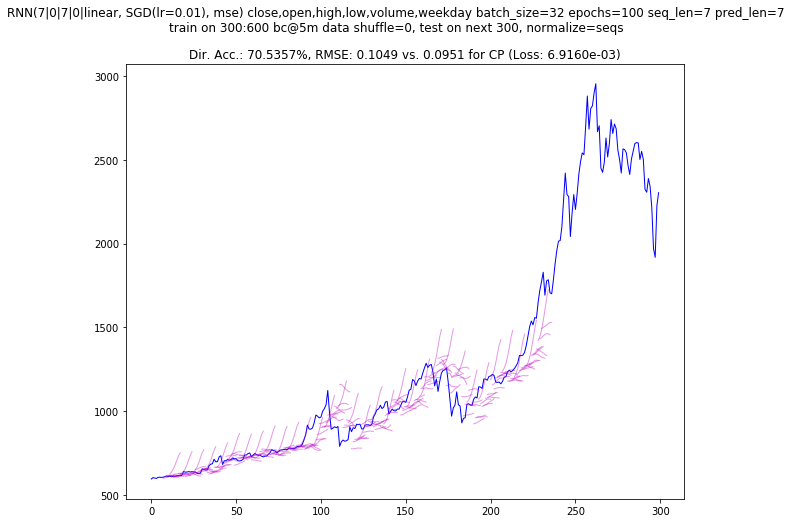

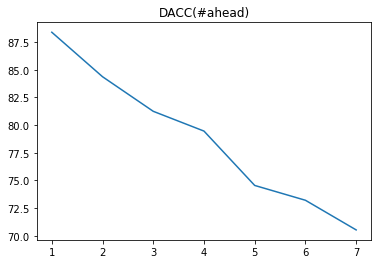

--- 13.313s to run segment


   ------ RUN 900 (from 600, train on 300, test on 300)

data ~ (600, 6)
--- 0.018s to model compilation time


--- Created model id: 140522145570384
Tensor("lstm_5_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 7, 7)              392       
_________________________________________________________________
lstm_6 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
Total params: 820
Trainable params: 820
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_3/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 262 samples, validate on 30 samples
Epoch 1/100
262/262 [==============================] - 1s 4ms/st

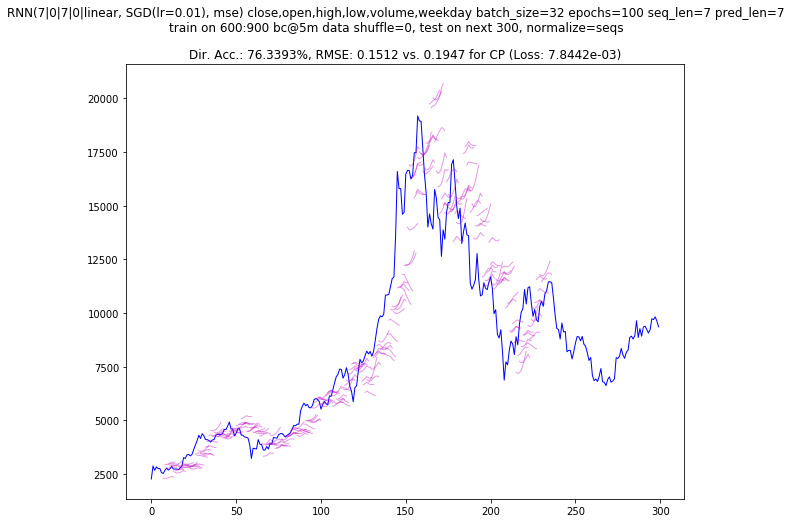

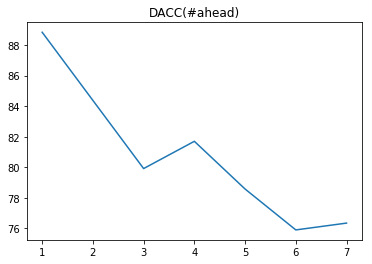

--- 13.436s to run segment

--- 38.230s to full run 300 - 1051



In [9]:
iOHLCW_FILE = './full_results/btc24h_ohlcw.i.csv'
full_run(300, 1051, out_filename=iOHLCW_FILE, write_csv_header=True,
         params=dict(OHLCW_PARAMS, model_maker=initial_model_constructor))

In [10]:
r = pd.read_csv(iOHLCW_FILE)
dd(r)
print("> DACC: %.2f%%" % r['dir_acc'].str.replace('%', '').astype(float).mean())
print("> RMSE: %.4f, vs. %.4f for CP" % (
    r['rmse'].str.replace('%', '').astype(float).mean(),
    r['rmse_cp'].str.replace('%', '').astype(float).mean(),
))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(7|0|7|0|linear, SGD(lr=0.01), mse) close,o...",0,300,300,False,seqs,0.003932,0.0929%,0.1039%,70.0893%
1,"RNN(7|0|7|0|linear, SGD(lr=0.01), mse) close,o...",300,600,300,False,seqs,0.006916,0.1049%,0.0951%,70.5357%
2,"RNN(7|0|7|0|linear, SGD(lr=0.01), mse) close,o...",600,900,300,False,seqs,0.007844,0.1512%,0.1947%,76.3393%


> DACC: 72.32%
> RMSE: 0.1163, vs. 0.1312 for CP


### refined


   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 6)
--- 0.178s to model compilation time


--- Created model id: 140522716862608
Tensor("lstm_7_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 7, 7)              392       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 8         
Total params: 820
Trainable params: 820
Non-trainable params: 0
____

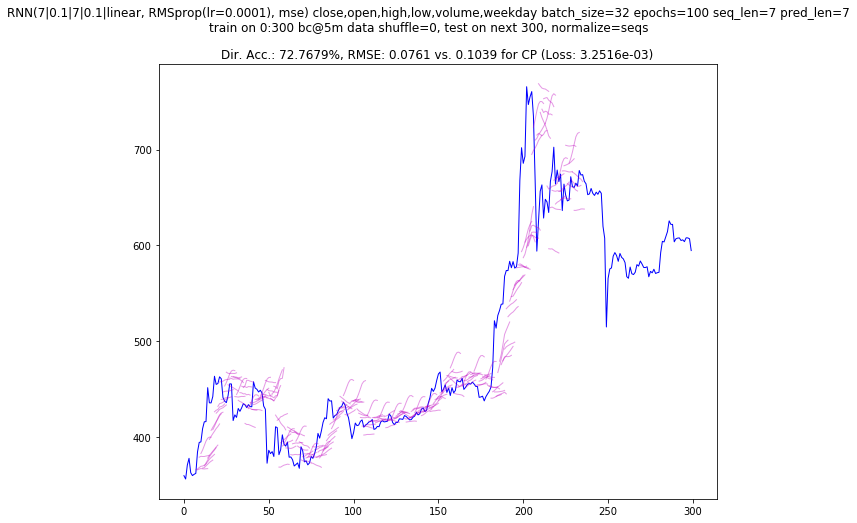

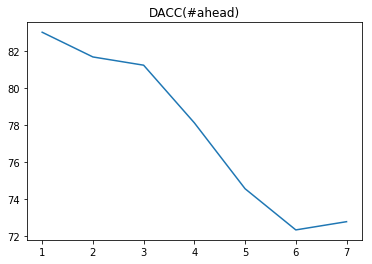

--- 15.853s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 6)
--- 0.023s to model compilation time


--- Created model id: 140522060622736
Tensor("lstm_9_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 7, 7)              392       
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_4 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8         
Total params: 820
Trainable params: 82

262/262 [==============================] - 0s 368us/step - loss: 0.0063 - val_loss: 0.0012
Epoch 68/100
262/262 [==============================] - 0s 340us/step - loss: 0.0060 - val_loss: 0.0012
Epoch 69/100
262/262 [==============================] - 0s 353us/step - loss: 0.0059 - val_loss: 0.0012
Epoch 70/100
262/262 [==============================] - 0s 393us/step - loss: 0.0057 - val_loss: 0.0012
Epoch 71/100
262/262 [==============================] - 0s 358us/step - loss: 0.0064 - val_loss: 0.0012
Epoch 72/100
262/262 [==============================] - 0s 341us/step - loss: 0.0056 - val_loss: 0.0012
Epoch 73/100
262/262 [==============================] - 0s 331us/step - loss: 0.0060 - val_loss: 0.0012
Epoch 74/100
262/262 [==============================] - 0s 321us/step - loss: 0.0063 - val_loss: 0.0012
Epoch 75/100
262/262 [==============================] - 0s 325us/step - loss: 0.0062 - val_loss: 0.0012
Epoch 76/100
262/262 [==============================] - 0s 366us/step - loss:

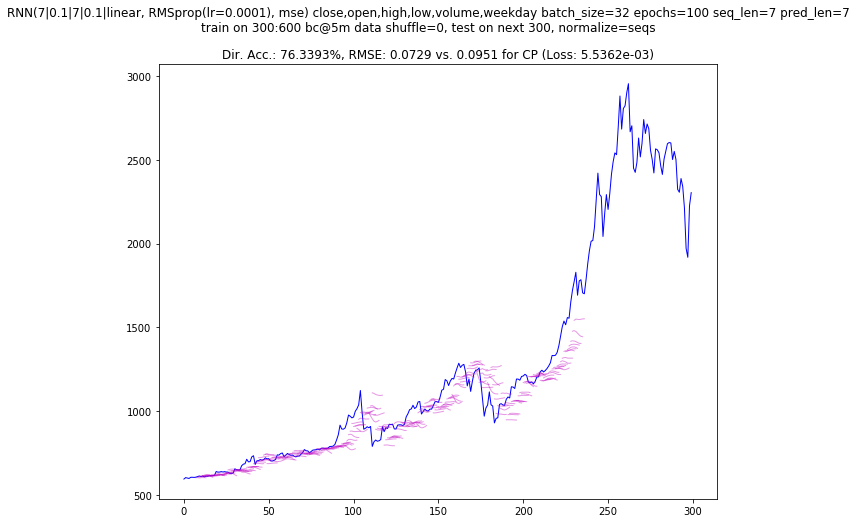

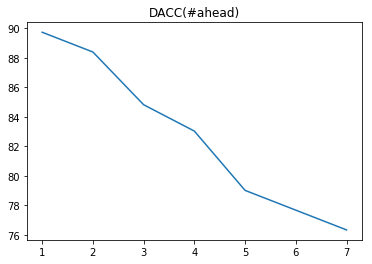

--- 14.284s to run segment


   ------ RUN 900 (from 600, train on 300, test on 300)

data ~ (600, 6)
--- 0.225s to model compilation time


--- Created model id: 140522024927888
Tensor("lstm_11_input:0", shape=(?, 7, 6), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 7, 7)              392       
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_6 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 8         
Total params: 820
Trainable params: 8

262/262 [==============================] - 0s 431us/step - loss: 0.0082 - val_loss: 0.0099
Epoch 68/100
262/262 [==============================] - 0s 473us/step - loss: 0.0088 - val_loss: 0.0100
Epoch 69/100
262/262 [==============================] - 0s 432us/step - loss: 0.0083 - val_loss: 0.0101
Epoch 70/100
262/262 [==============================] - 0s 398us/step - loss: 0.0087 - val_loss: 0.0099
Epoch 71/100
262/262 [==============================] - 0s 383us/step - loss: 0.0085 - val_loss: 0.0099
Epoch 72/100
262/262 [==============================] - 0s 375us/step - loss: 0.0090 - val_loss: 0.0099
Epoch 73/100
262/262 [==============================] - 0s 391us/step - loss: 0.0087 - val_loss: 0.0098
Epoch 74/100
262/262 [==============================] - 0s 367us/step - loss: 0.0083 - val_loss: 0.0097
Epoch 75/100
262/262 [==============================] - 0s 349us/step - loss: 0.0091 - val_loss: 0.0097
Epoch 76/100
262/262 [==============================] - 0s 381us/step - loss:

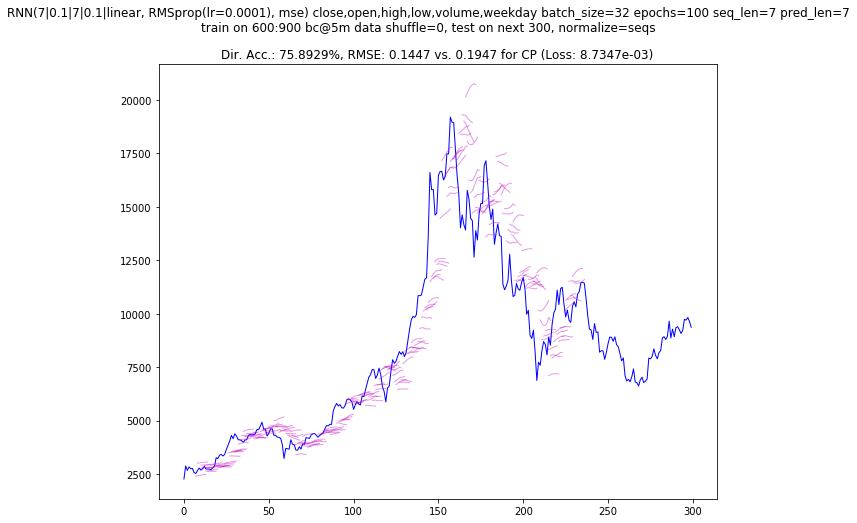

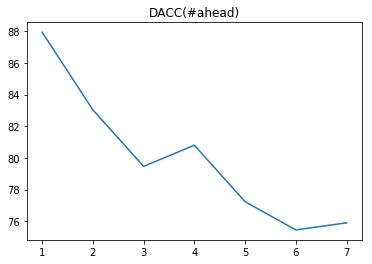

--- 15.122s to run segment

--- 45.259s to full run 300 - 1051



In [11]:
OHLCW_FILE = './full_results/btc24h_ohlcw.csv'
full_run(300, 1051, out_filename=OHLCW_FILE, write_csv_header=True, params=OHLCW_PARAMS)

In [12]:
r = pd.read_csv(OHLCW_FILE)
dd(r)
print("> DACC: %.2f%%" % r['dir_acc'].str.replace('%', '').astype(float).mean())
print("> RMSE: %.4f, vs. %.4f for CP" % (
    r['rmse'].str.replace('%', '').astype(float).mean(),
    r['rmse_cp'].str.replace('%', '').astype(float).mean(),
))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...",0,300,300,False,seqs,0.003252,0.0761%,0.1039%,72.7679%
1,"RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...",300,600,300,False,seqs,0.005536,0.0729%,0.0951%,76.3393%
2,"RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...",600,900,300,False,seqs,0.008735,0.1447%,0.1947%,75.8929%


> DACC: 75.00%
> RMSE: 0.0979, vs. 0.1312 for CP


## OHLCW + SP500 features predictions


   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 8)
--- 0.025s to model compilation time


--- Created model id: 140522007229776
Tensor("lstm_13_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_8 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 8         
Total params: 876
Trainable params: 876
Non-trainable params: 0
___

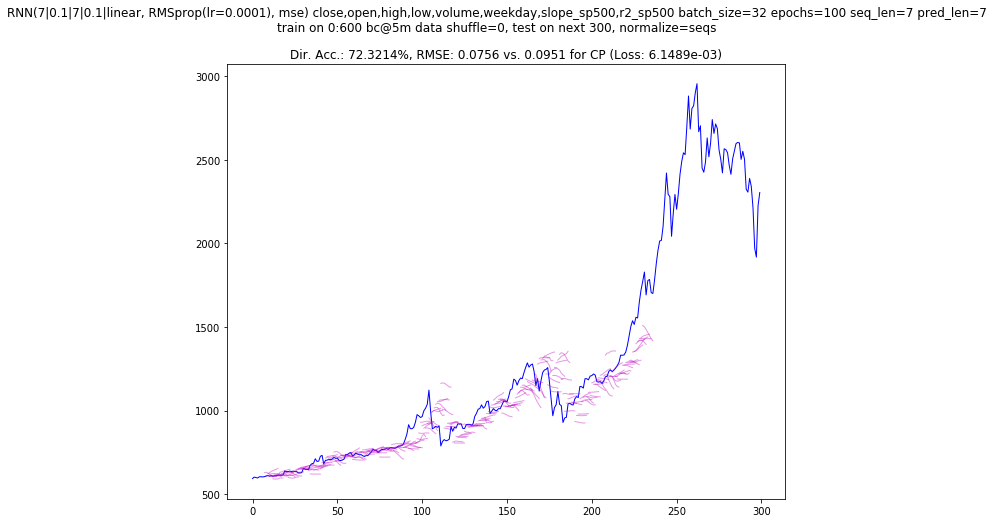

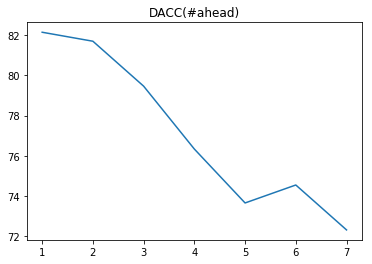

--- 22.897s to run segment


   ------ RUN 900 (from 300, train on 600, test on 300)

data ~ (900, 8)
--- 0.018s to model compilation time


--- Created model id: 140522007648912
Tensor("lstm_15_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_10 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 8         
Total params: 876
Trainable params: 8

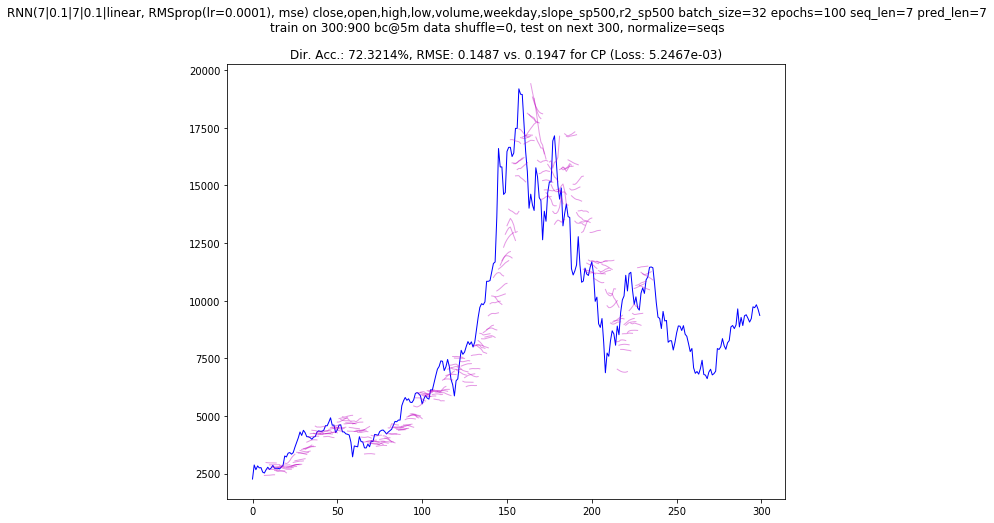

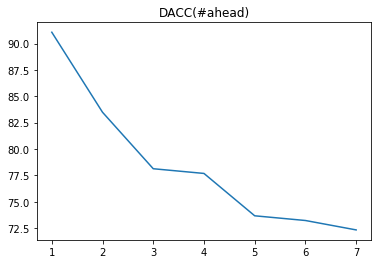

--- 22.995s to run segment

--- 45.892s to full run 600 - 1052



In [13]:
OHLCW_SP500_FILE = './full_results/btc24h_ohlcw_sp500.csv'
OHLCW_PARAMS_SP500 = DEFAULT_PARAMS.copy()
OHLCW_PARAMS_SP500['train_sz'] = 600
OHLCW_PARAMS_SP500['features'] = [
    'close', 'open', 'high', 'low', 'volume', 'weekday',
    'slope_sp500', 'r2_sp500',
]
full_run(600, len(data) - 300 - 7, out_filename=OHLCW_SP500_FILE, write_csv_header=True, params=OHLCW_PARAMS_SP500)

In [14]:
r = pd.read_csv(OHLCW_SP500_FILE)
dd(r)
print("> DACC: %.2f%%" % r['dir_acc'].str.replace('%', '').astype(float).mean())
print("> RMSE: %.4f, vs. %.4f for CP" % (
    r['rmse'].str.replace('%', '').astype(float).mean(),
    r['rmse_cp'].str.replace('%', '').astype(float).mean(),
))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...",0,600,300,False,seqs,0.006149,0.0756%,0.0951%,72.3214%
1,"RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...",300,900,300,False,seqs,0.005247,0.1487%,0.1947%,72.3214%


> DACC: 72.32%
> RMSE: 0.1121, vs. 0.1449 for CP


## OHLCW + SP500 + sentiment predictions


   ------ RUN 600 (from 0, train on 600, test on 300)

data ~ (900, 9)
--- 0.020s to model compilation time


--- Created model id: 140522010274896
Tensor("lstm_17_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 7, 7)              476       
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_12 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 8         
Total params: 904
Trainable params: 904
Non-trainable params: 0
___

532/532 [==============================] - 0s 275us/step - loss: 0.0065 - val_loss: 0.0045
Epoch 68/100
532/532 [==============================] - 0s 297us/step - loss: 0.0065 - val_loss: 0.0045
Epoch 69/100
532/532 [==============================] - 0s 302us/step - loss: 0.0068 - val_loss: 0.0045
Epoch 70/100
532/532 [==============================] - 0s 297us/step - loss: 0.0064 - val_loss: 0.0045
Epoch 71/100
532/532 [==============================] - 0s 285us/step - loss: 0.0069 - val_loss: 0.0046
Epoch 72/100
532/532 [==============================] - 0s 325us/step - loss: 0.0063 - val_loss: 0.0045
Epoch 73/100
532/532 [==============================] - 0s 293us/step - loss: 0.0064 - val_loss: 0.0045
Epoch 74/100
532/532 [==============================] - 0s 278us/step - loss: 0.0065 - val_loss: 0.0045
Epoch 75/100
532/532 [==============================] - 0s 292us/step - loss: 0.0062 - val_loss: 0.0044
Epoch 76/100
532/532 [==============================] - 0s 281us/step - loss:

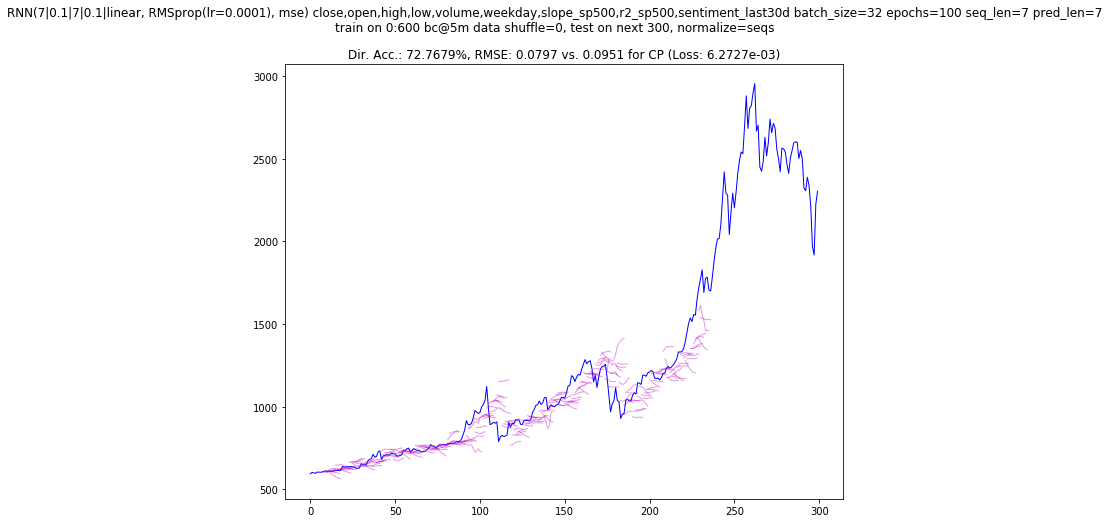

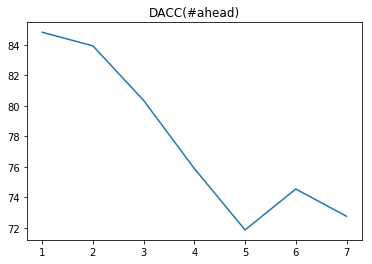

--- 20.932s to run segment


   ------ RUN 900 (from 300, train on 600, test on 300)

data ~ (900, 9)
--- 0.018s to model compilation time


--- Created model id: 140521482646416
Tensor("lstm_19_input:0", shape=(?, 7, 9), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 7, 7)              476       
_________________________________________________________________
dropout_13 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_14 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 8         
Total params: 904
Trainable params: 9

532/532 [==============================] - 0s 273us/step - loss: 0.0069 - val_loss: 0.0172
Epoch 68/100
532/532 [==============================] - 0s 278us/step - loss: 0.0074 - val_loss: 0.0172
Epoch 69/100
532/532 [==============================] - 0s 274us/step - loss: 0.0068 - val_loss: 0.0172
Epoch 70/100
532/532 [==============================] - 0s 279us/step - loss: 0.0073 - val_loss: 0.0171
Epoch 71/100
532/532 [==============================] - 0s 284us/step - loss: 0.0072 - val_loss: 0.0171
Epoch 72/100
532/532 [==============================] - 0s 287us/step - loss: 0.0070 - val_loss: 0.0171
Epoch 73/100
532/532 [==============================] - 0s 286us/step - loss: 0.0076 - val_loss: 0.0171
Epoch 74/100
532/532 [==============================] - 0s 326us/step - loss: 0.0062 - val_loss: 0.0171
Epoch 75/100
532/532 [==============================] - 0s 298us/step - loss: 0.0066 - val_loss: 0.0170
Epoch 76/100
532/532 [==============================] - 0s 324us/step - loss:

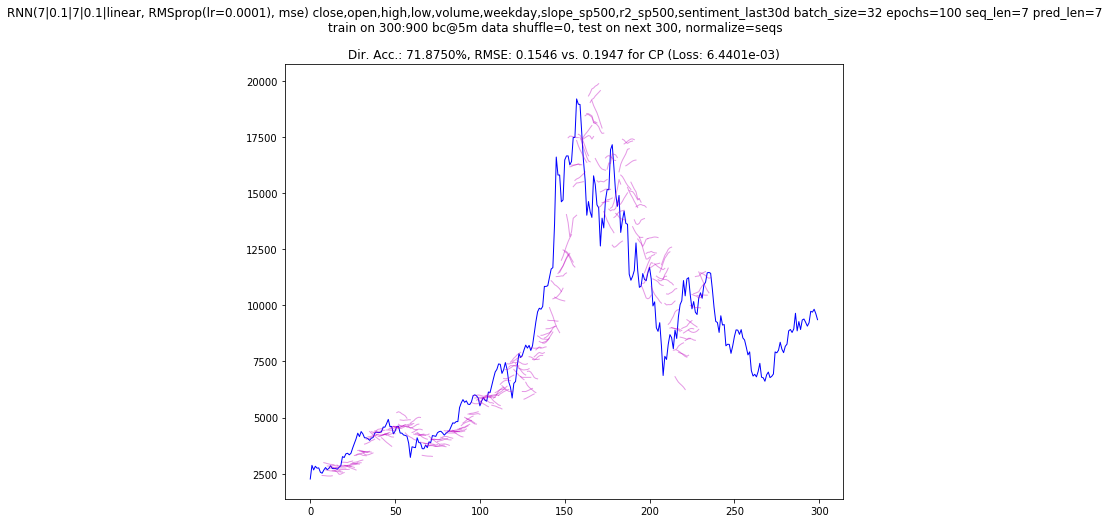

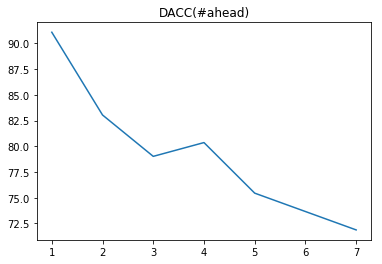

--- 21.169s to run segment

--- 42.102s to full run 600 - 1052



In [15]:
OHLCW_SP500_ST_FILE = './full_results/btc24h_ohlcw_sp500_st.csv'
OHLCW_PARAMS_SP500_ST = DEFAULT_PARAMS.copy()
OHLCW_PARAMS_SP500_ST['train_sz'] = 600
OHLCW_PARAMS_SP500_ST['features'] = [
    'close', 'open', 'high', 'low', 'volume', 'weekday',
    'slope_sp500', 'r2_sp500',
    'sentiment_last30d'
]
full_run(600, len(data) - 300 - 7, out_filename=OHLCW_SP500_ST_FILE, write_csv_header=True, params=OHLCW_PARAMS_SP500_ST)

In [16]:
r = pd.read_csv(OHLCW_SP500_ST_FILE)
dd(r)
print("> DACC: %.2f%%" % r['dir_acc'].str.replace('%', '').astype(float).mean())
print("> RMSE: %.4f, vs. %.4f for CP" % (
    r['rmse'].str.replace('%', '').astype(float).mean(),
    r['rmse_cp'].str.replace('%', '').astype(float).mean(),
))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...",0,600,300,False,seqs,0.006273,0.0797%,0.0951%,72.7679%
1,"RNN(7|0.1|7|0.1|linear, RMSprop(lr=0.0001), ms...",300,900,300,False,seqs,0.006440,0.1546%,0.1947%,71.8750%


> DACC: 72.32%
> RMSE: 0.1171, vs. 0.1449 for CP


## LR model for comparison

data ~ (1359, 1)
--- 0.000s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210)...
> Predicting (now at 220)...
> Predicting (now at 230)...
> Predicting (now at 240)...
> Predicting (now at 250)...
> Predicting (now at 260)...
> Predicting (now at 270)...
> Predicting (now at 280)...
> Predicting (now at 290)...
> Predicting (now at 300)...
> Predicting (now at 310)...
> Predicting (now at 320)...
> Predicti

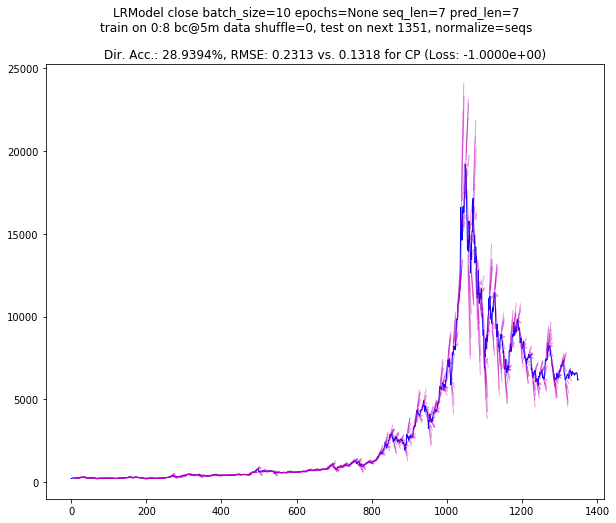

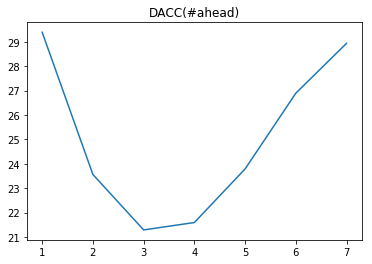

{'dir_acc': u'28.9394%',
 'model_description': u'LRModel close batch_size=10 epochs=None seq_len=7 pred_len=7',
 'normalize': u'seqs',
 'rmse': u'0.2313%',
 'rmse_cp': u'0.1318%',
 'shuffle': False,
 'test_on': 1351,
 'train_from': 0,
 'train_to': 8,
 'train_val_losses': [],
 'training_loss': u'-1.0000e+00'}

In [18]:
run_walk_forward_validation_rnn(
    # data to extract:
    data,
    features=['close'],
    from_i=0,
    train_sz=8,
    test_sz=len(data) - 8,
    # data processing:
    normalize='seqs',  # 'seqs' | 'data'
    detrend=False,
    # model and prediction arrangement:
    seq_len=7,
    pred_len=7,
    model_maker=LRModel,
    # training:
    epochs=None,
    batch_size=10,
    shuffle=False,
    # experiment setup:
    times=1,
    skip=False,
    fix_all_rngs_to=False,
    fix_rngs_before_each=False,
    # plotting:
    fig_size=(10, 8),
    fast=False,
)

## ARIMA for reference

In [ ]:
run_walk_forward_validation_arima(
    # data to extract:
    data,
    features=['close'],
    from_i=0,
    train_sz=600,
    test_sz=300,
    # data processing:
    normalize=False,
    order=(3, 1, 2),
    pred_len=100,
    skip=False,
    fix_all_rngs_to=False,
    fix_rngs_before_each=False,
)